# Exercise 1 - Ordinary Least Squares (20 Points)

The first exercise is about linear models.
The given data set contains prices and other attributes of approximately 54,000 diamonds. You should fit a linear model to predict the price of a diamond, given its attributes.

This exercise is meant to get you started with the tool stack. Besides numpy and matplotlib we use the following python packages:

- [pandas](https://pandas.pydata.org/)
- [sklearn](http://scikit-learn.org/)

If you are unfamiliar with them, follow the documentation links. In the event of a persistent problem, do not hesitate to contact the course instructors.

- christoph.staudt@uni-jena.de

### Submission

- Deadline of submission:
        28.04.2021 23:59
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=28746)


## Preprocessing

We use the same notation as in the lecture.
- $m$... Number of datapoints
- $n$... Number of features

### Dataset 

As a dataset, we use the famous [diamond dataset](https://www.kaggle.com/shivam2503/diamonds).

Each element in this dataset represents a diamond and has the following features:

- price: price in US dollars (326.0 - 18823.0)
- carat: weight of the diamond (0.2 - 5.01)
- cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color: diamond colour, from J (worst) to D (best)
- clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- x: length in mm (0-10.74)
- y: width in mm (0-58.9)
- z: depth in mm (0-31.8)
- depth: total depth percentage = 2 * z / (x + y) (43-79)
- table: width of top of diamond relative to widest point (43-95)

The dataset is stored under `diamonds.csv`.

### Task 1 (1 Point)
Import the data from the file using [pandas](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) and examine it.

Determine the following:

* The number of data points
* The column names
* The data types for each column

In [74]:
import pandas as pd

df = pd.read_csv("diamonds.csv")
m = df.size
columns = list(df.columns)
dtypes = dict(df.dtypes)
print(f"number of data points:\n{m}\n\ncolumn names:\n{columns}\n\ndata types:\n{dtypes}")

number of data points:
539400

column names:
['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']

data types:
{'carat': dtype('float64'), 'cut': dtype('O'), 'color': dtype('O'), 'clarity': dtype('O'), 'depth': dtype('float64'), 'table': dtype('float64'), 'price': dtype('int64'), 'x': dtype('float64'), 'y': dtype('float64'), 'z': dtype('float64')}


### Task 2 (1 Point)

Since there are discrete variables and we do not yet know how to include them into our regression model, remove them. Additionally, verify that there are no missing values in our dataset.

Hint: there are multiple ways to [check](https://towardsdatascience.com/how-to-check-for-missing-values-in-pandas-d2749e45a345) for missing values

In [75]:
removed_columns = [column for column in df.columns if df.dtypes[column] == object]
df = df.drop(columns=removed_columns)
assert not df.isna().any().any()

print(f"removed: {removed_columns}")
print(f"remaining: {list(df.columns)}")

removed: ['cut', 'color', 'clarity']
remaining: ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']


As discussed in the lecture, we should **standardize** the data, to make different scales comparable.

Standardization is defined for each feature $x_i$:

\begin{align}
\hat{x}_i = \cfrac{x_i-\mu_x}{\sigma_x}\,,
\end{align}
where $\mu_x$ and $\sigma_x$ are the empirical [mean](https://en.wikipedia.org/wiki/Mean) and [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation) of the feature $x$.

### Task 3 (2 Points)

Convert the pandas dataframe to a numpy array and calculate the standardized data matrix $X$.

In [76]:
import numpy as np

view = df.to_numpy()
mean = np.mean(view, axis=0)
std = np.std(view, axis=0)
view = (view - mean) / std
# (x^(1), x^(2), ..., x^(m))
X = np.matrix(view).T

### Task 4 (2 Points)

Scikit learn has an [implementation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) of this preprocessing.

Use it to create a second standardized data matrix and compare this result with your result from Task 3. 

In [77]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# should i use scaler.fit_transform(df) here?
scaler.fit(df)
standardized_df = scaler.transform(df)
# see where this differs from our own implementation
diff = standardized_df - view
print(f"max diff: {np.max(diff)}")

max diff: 0.0


### Task 5 (2 Points)

Visualizing correlation in your data often helps to build intuition and get a feeling of the deeper mojo in the set.

Here we want to use the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) as a measure for correlation between two variables.

Let $x$ and $y$ be two variables of the unstandardized dataset (e.g. `carat` and `price`). The empirical Pearson correlation coefficient between $x$ and $y$ is defined as 

\begin{align}
r_{xy} = \cfrac{\sum_{i=1}^n(x_i-\bar{x})(y_i-\bar{y})}{\sqrt{\sum_{i=1}^n(x_i-\bar{x})^2}\sqrt{\sum_{i=1}^n(y_i-\bar{y})^2}}\,,
\end{align}
where $\bar{x}$ and $\bar{y}$ are the respective empirical means.

---

How does this definition translate to our standardized data matrix $X$?

Calculate the pairwise correlation matrix for our dataset. 

Visualize this correlation matrix and label the rows/columns. Using [imshow](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.imshow.html?highlight=imshow) with a color map produces nice results.

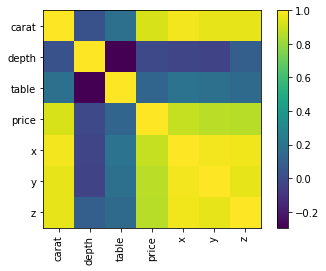

In [78]:
import matplotlib.pyplot as plt

n = X.shape[0]
m = X.shape[1]

correlation_matrix = X @ X.T / m

plt.imshow(correlation_matrix)
# is this possible without explicitly setting the ticks (range(n)) again?
plt.xticks(range(n), list(df.columns), rotation='vertical')
plt.yticks(range(n), list(df.columns))
plt.colorbar()
plt.show()

## Linear Regression

The goal is to predict the `price` of a diamond based on some of its other features.

### Task 6 (1 Point)
Make a scatter plot of `carat` vs `price` using Matplotlib. Label the axes and give the plot a title.

Use the standardized dataset.

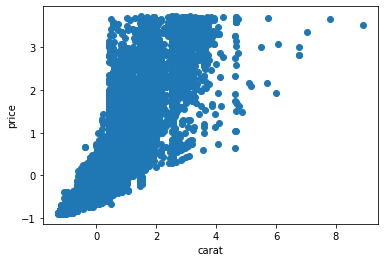

In [79]:
carat = standardized_df[:,df.columns.get_loc('carat')]
price = standardized_df[:,df.columns.get_loc('price')]
plt.scatter(carat, price)
plt.xlabel('carat')
plt.ylabel('price')
plt.show()

### Task 7 (4 Points)

Implement a `LinReg` class, that uses maximum likelihood estimation (see the lecture script) to estimate $\theta$. Add the possibility to use [Ridge Regression](https://en.wikipedia.org/wiki/Ridge_regression).

In [80]:
class LinReg():
    def __init__(self, c=0):
        self.c = c
        self.theta = None
    
    def fit(self, X, Y):
        # X shape: (n_features, n_samples)
        # Y shape: (n_samples, 1)
        XXT = X @ X.T
        self.theta = np.linalg.solve(XXT + self.c * np.eye(XXT.shape[0]), X @ Y)
        
    def predict(self, X):
        # X shape: (n_features, n_samples)
        return self.theta.T @ X

### Task 8 (2 Points)

Here you want to predict the `price` of a diamond solely from the variable `carat`. 
Set up the design matrix for this case and use your class to estimate $\theta$ on the dataset.
Note, that the design matrix does **not** need the vector of ones, since we standardized the dataset.

Plot the regression line defined by $\theta$.

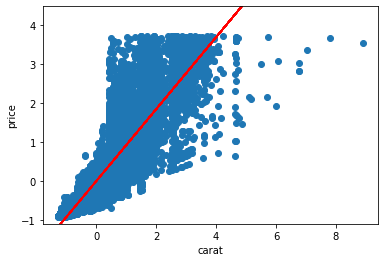

In [81]:
X = np.array([carat])
Y = np.array([price]).T

linreg = LinReg()
linreg.fit(X, Y)
PREDICTION = linreg.predict(X)

# we got matrices, we want an arrays to plot it
x = X[0]
y = Y[:,0]
prediction = PREDICTION[0]

# plot data
plt.scatter(x, y)
# plot regression
plt.plot(x, prediction, color='red')
# labels
plt.xlabel('carat')
plt.ylabel('price')
# set plotting range properly
plt.ylim((np.min(y) * 1.2, np.max(y) * 1.2))
plt.show()

### Task 9 (2 Points)

You can find an implementation of this method in the python module [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Use it and compare your result for the estimation of $\theta$.

In [82]:
from sklearn.linear_model import LinearRegression

sk_linreg = LinearRegression()
# shape: (n_samples, n_features) -> X.T
sk_linreg.fit(X.T, Y)
print(sk_linreg.coef_ - linreg.theta.T)

[[1.44328993e-15]]


### Task 10 (3 Points)

Now predict the `price` from the variables `carat`, `depth`, `table`, `x`, `y`, `z`.

- Estimate $\theta$ with your class
- Estimate $\theta$ with scikit learn
- Compare both estimations

In [83]:
columns = [df.columns.get_loc(col_name) for col_name in ['carat', 'depth', 'table', 'x', 'y', 'z']]
X = standardized_df[:, columns].T
# Y was already built last time

linreg = LinReg()
linreg.fit(X, Y)

sk_linreg = LinearRegression()
# shape: (n_samples, n_features) -> X.T
sk_linreg.fit(X.T, Y)
print(np.max(sk_linreg.coef_ - linreg.theta.T))

3.0801750039444187e-14
